# Deep Learning: Assignment #2
## Submission date: 24/12/2025, 23:59.
### Topics:
- Regularization
- Batch Normalization
- Convolutional Neural Networks
- Semantic Segmentation


**Submitted by:**

- **Student 1 (Mahmoud Abade, 206773756)**
- **Student 2 (Feras Dwere, 214225021)**  


**Assignment Instructions:**

· Submissions are in **pairs only**. Write both names + IDs at the top of the notebook.

· Keep your code **clean, concise, and readable**.

· You may work in your IDE, but you **must** paste the final code back into the **matching notebook cells** and run it there.  


· <font color='red'>Write your textual answers in red.</font>  
(e.g., `<span style="color:red">your answer here</span>`)

· All figures, printed results, and outputs should remain visible in the notebook.  
Run **all cells** before submitting and **do not clear outputs**.

· Use relative paths — **no absolute file paths** pointing to local machines.

· **Important:** Your submission must be entirely your own.  
Any form of plagiarism (including uncredited use of ChatGPT or AI tools) will result in **grade 0** and disciplinary action.


In [1]:
# --- Global Setup ---

# Import Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import random
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.init as init
from tqdm import tqdm
import os
from glob import glob
import pandas as pd
from PIL import Image
import zipfile


# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## task

In [2]:
# Suggesed uploading script
! pip install -q kaggle
! mkdir ~/.kaggle

In [3]:
import json
import os

# Define Kaggle credentials
kaggle_username = 'mahmoud abade'
kaggle_api_key = 'KGAT_9252f19df0b8b2f8c8407589e61caf35'

# Create the JSON content
kaggle_json_content = {
    "username": kaggle_username,
    "key": kaggle_api_key
}

# Define the path to kaggle.json
kaggle_dir = os.path.expanduser('~/.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Write the JSON content to the file
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_json_content, f)

print(f"Created {kaggle_json_path} with Kaggle credentials.")

Created /root/.kaggle/kaggle.json with Kaggle credentials.


In [4]:
import os

kaggle_json_path = os.path.join(os.path.expanduser('~/.kaggle'), 'kaggle.json')
os.chmod(kaggle_json_path, 0o600)

print(f"Set permissions for {kaggle_json_path} to 0o600 (read/write for owner only).")

Set permissions for /root/.kaggle/kaggle.json to 0o600 (read/write for owner only).


In [5]:
! kaggle datasets download jcoral02/camvid
! unzip -q camvid.zip -d q2
! mkdir Question2
! cp -rf q2/CamVid/. Question2
! rm -rf q2

Dataset URL: https://www.kaggle.com/datasets/jcoral02/camvid
License(s): unknown
 97% 1.09G/1.12G [00:07<00:00, 113MB/s]
100% 1.12G/1.12G [00:07<00:00, 154MB/s]


## Question 1: Convolutional Digit Classification on SVHN (25 Points)

In this question, our goal is to implement a Convolutional Neural Network (CNN) for image classification on the The Street View House Numbers (SVHN) Dataset. The dataset consists of read-world house number images.

**source:** http://ufldl.stanford.edu/housenumbers/

### Data Loading and Preprocessing

In this section we will load, explore and preprocess the dataset for training.

You are given the **SVHN** (Street View House Numbers) dataset: a collection of real-world images of digits (0–9) captured from house numbers in Google Street View. Each image is 32×32 pixels and contains three color channels (RGB). The goal is to classify each image into one of the 10 digit classes (0 – 9).

The dataset will be downloaded automatically to the local environment using the `torchvision.datasets.SVHN` class.

For this section, implement the preprocessing procedure and explain your choice, then create the loaders for the train and test sets.



In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the SVHN Letters dataset
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset  = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Inspect the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Get one image and label
image, label = train_dataset[0]
print(f"Shape of one image: {image.shape} (C x H x W)")
print(f"Label of first image: {label}")

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 182M/182M [00:04<00:00, 37.1MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 36.7MB/s]


Number of training samples: 73257
Number of testing samples: 26032
Shape of one image: torch.Size([3, 32, 32]) (C x H x W)
Label of first image: 1


Finally, run the cell below to take a look at a few sample images to better understand the dataset we're working with.

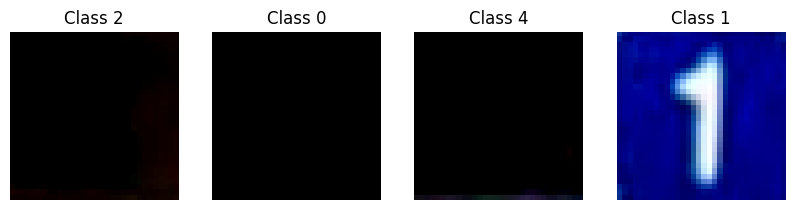

In [ ]:
images, labels = next(iter(train_loader))

# Show first 4 images
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
  img = images[i].permute(1, 2, 0).numpy()
  #img = np.clip(img * 0.229 + 0.485, 0, 1)  # unnormalize for display
  axes[i].imshow(img)
  axes[i].set_title(f"Class {labels[i].item()}")
  axes[i].axis('off')
plt.show()

**Answer the following Questions:**

<font color="red">1. How is SVHN fundamentally harder than MNIST?</font>  
<font color="red">SVHN is fundamentally harder than MNIST because it consists of real-world images from Google Street View, meaning the digits are embedded in natural scenes with cluttered backgrounds, variable lighting conditions, and different fonts/styles. Unlike MNIST, which has centered, clean, handwritten digits on a black background, SVHN images are RGB (3 color channels) and often contain parts of neighboring digits.</font>

<font color="red">2. Which preprocessing or architectural choices become necessary because of this difference?</font>
<font color="red">Because of the color complexity and background clutter, we need deeper architectures with convolutional layers to extract hierarchical features (edges, textures, shapes) rather than simple fully connected networks. We also need to process 3 input channels (RGB) instead of 1. Preprocessing steps like Normalization (mean subtraction and scaling) are crucial to help the model converge faster given the varying pixel intensity distributions in real-world images.</font>



### CNN Architecture Design

We will design a convolutional neural network (inspired by AlexNet) for digit classification.
The network consists of **three convolutional feature-extraction stages**, followed by a **two-layer fully connected classifier**.

Your architecture must follow the structure below:

- Convolutional Layer with 32 output channels, kernel size = 3×3, stride = 1, padding = 1
- ReLU activation function
- MaxPooling Layer with a kernel size of 3×3 and a stride of 2

- Convolutional Layer with 64 output channels, kernel size = 3×3, stride = 1, padding = 1
- ReLU activation function.
- Convolutional Layer with 128 output channels, kernel size = 3×3, stride = 1, padding = 1

- ReLU activation function.

- MaxPooling Layer with a kernel size of 3×3 and a stride of 2.

- Dropout Layer  with a dropout probability of 0.5.

- Fully Connected Layer with output size of 128.

- ReLU activation function

- Dropout Layer  with a dropout probability of 0.5.

- Fully Connected Layer with output size of 10 (for the 10 digit classes, 0–9).



In [ ]:

class SVHN_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SVHN_CNN, self).__init__()

        # Block 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Block 2: Conv -> ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Block 3: Conv -> ReLU -> MaxPool
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Dropout
        self.dropout1 = nn.Dropout(p=0.5)

        # FC layers
        # Calculation for input size:
        # Input: 32x32
        # After pool1 (k=3, s=2): floor((32-3)/2 + 1) = 15 -> 15x15
        # After pool3 (k=3, s=2): floor((15-3)/2 + 1) = 7 -> 7x7
        self.flatten_dim = 128 * 7 * 7

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2(x))

        # Block 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


**Answer the following Questions:**

<font color="red">1. Which part(s) of your CNN most strongly influence receptive field size?</font>  
<font color="red">The convolutional kernel sizes, strides, and especially the pooling layers (which increase the stride effectively) most strongly influence the receptive field size. Stacking multiple convolutional layers also increases the receptive field linearly, but pooling/strided convolutions increase it multiplicatively (relative to the input).</font>

<font color="red">2. Why does receptive field matter for recognizing digits embedded in cluttered scenes?</font>
<font color="red">A larger receptive field allows the neuron to "see" more of the input image at once. This is critical for context. In cluttered scenes, the network needs to distinguish the digit from the background noise. If the receptive field is too small, the network might only see a curve or a line and confuse it with background texture. A sufficiently large receptive field ensures the network captures the entire digit and its immediate context to make a correct classification.</font>



Now we will setup all training parameters and train the model.

Your tasks in this section are to create an instance of the model and choose and explain your choice of optimizer and loss function.
3. Fill the missing code in the training function.
4. Train the model for ~6 epochs on the training set (in colab CPU should take ~30 mins).

In [ ]:

# Create model instance
model = SVHN_CNN(num_classes=10)

# Loss function: CrossEntropyLoss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam is a good default choice for faster convergence compared to SGD
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


SVHN_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Now, fill in the missing code for the training function and train the model for 10 epochs.

In [ ]:

def train_model(model, train_loader, criterion, optimizer, DEVICE, num_epochs=10):
  model.to(DEVICE)

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for better visualization
    loop = tqdm(train_loader, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      # Zero gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Update progress bar
      loop.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


In [ ]:

# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, DEVICE, num_epochs=10)


Epoch [1/10]: 100%|██████████| 573/573 [00:27<00:00, 20.86it/s, loss=0.884]


Epoch [1/10] Train Loss: 1.1643, Train Acc: 61.22%


Epoch [2/10]: 100%|██████████| 573/573 [00:26<00:00, 21.56it/s, loss=0.55]


Epoch [2/10] Train Loss: 0.6256, Train Acc: 80.70%


Epoch [3/10]: 100%|██████████| 573/573 [00:25<00:00, 22.26it/s, loss=0.593]


Epoch [3/10] Train Loss: 0.5367, Train Acc: 83.60%


Epoch [4/10]: 100%|██████████| 573/573 [00:26<00:00, 22.01it/s, loss=0.501]


Epoch [4/10] Train Loss: 0.4886, Train Acc: 85.34%


Epoch [5/10]: 100%|██████████| 573/573 [00:26<00:00, 21.94it/s, loss=0.322]


Epoch [5/10] Train Loss: 0.4488, Train Acc: 86.59%


Epoch [6/10]: 100%|██████████| 573/573 [00:26<00:00, 21.98it/s, loss=0.424]


Epoch [6/10] Train Loss: 0.4212, Train Acc: 87.25%


Epoch [7/10]: 100%|██████████| 573/573 [00:26<00:00, 21.77it/s, loss=0.311]


Epoch [7/10] Train Loss: 0.3942, Train Acc: 88.22%


Epoch [8/10]: 100%|██████████| 573/573 [00:26<00:00, 21.68it/s, loss=0.468]


Epoch [8/10] Train Loss: 0.3760, Train Acc: 88.90%


Epoch [9/10]: 100%|██████████| 573/573 [00:25<00:00, 22.16it/s, loss=0.506]


Epoch [9/10] Train Loss: 0.3646, Train Acc: 89.14%


Epoch [10/10]: 100%|██████████| 573/573 [00:26<00:00, 22.01it/s, loss=0.578]

Epoch [10/10] Train Loss: 0.3499, Train Acc: 89.60%


The following function evaluates a given model on the loaded test set. Use it to evaluate your trained model on the test set loader.

In [ ]:
def evaluate_model(model, loader):
  model.eval()
  model.to(DEVICE) # Ensure model is on the correct device
  correct, total = 0, 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(DEVICE), labels.to(DEVICE)
      outputs = model(images)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy
evaluate_model(model,test_loader) # Use the already trained model instance

Test Accuracy: 91.77%


91.76782421634911

**Answer the following Question:**

<font color="red">1. If training loss drops very quickly in the early epochs, is that always a good sign — or could it signal a potential problem?</font>

<font color="red">It is generally a good sign that learning is happening, but it's not *always* good. If it drops too precipitously and then plateaus immediately, it might indicate that the learning rate is too high (potentially causing instability later - zigzag) or that the model is overfitting to the easy examples very quickly. If the validation loss doesn't follow the training loss (i.e., val loss stays high or goes up), then a sharp drop in training loss signals overfitting. However, in the early stages of training a CNN on a dataset like SVHN, a quick initial drop is expected as the model learns basic features.</font>



### Visualizing Feature Maps

To deepen our understanding of what the CNN learns, we will visualize **feature maps** (activations) produced inside the network when passing a single image forward.

Feature maps show *where* the network detects edges, curves, textures, and higher-level structures.  

In this section, select one test image, pass it through the CNN and finally visualize activation maps from different convolution layers.


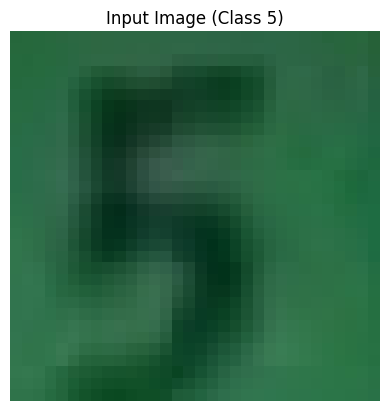

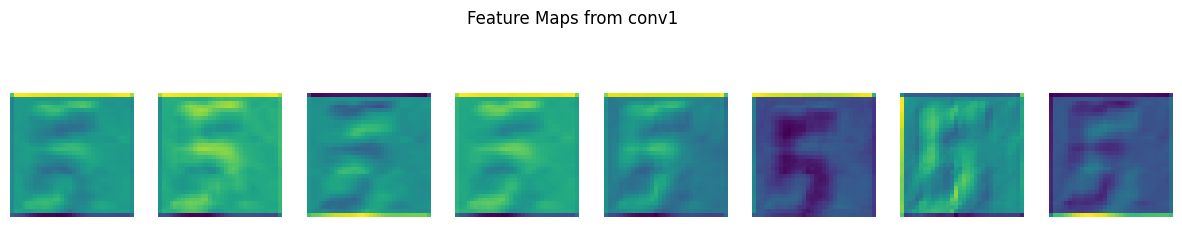

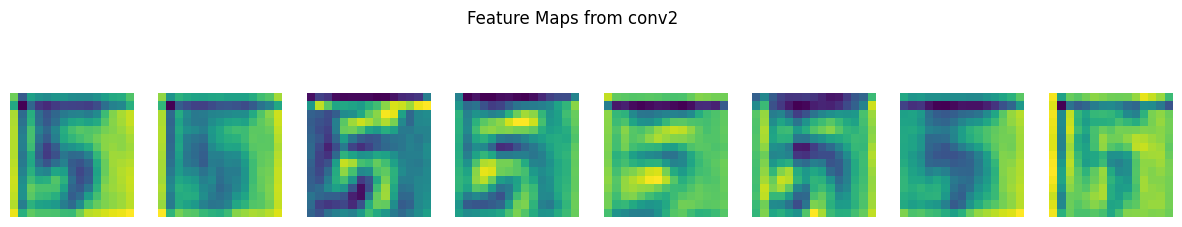

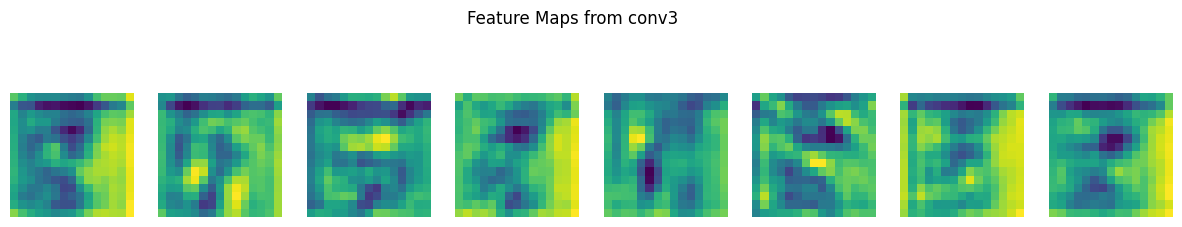

In [ ]:

# Get a single image
model.eval()
image, label = test_dataset[0]
input_tensor = image.unsqueeze(0).to(DEVICE)

# Function to get activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Forward pass
output = model(input_tensor)

# Visualize
def plot_feature_maps(layer_name, num_maps=8):
    act = activations[layer_name].cpu().squeeze()
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        if i < act.size(0):
            axes[i].imshow(act[i], cmap='viridis')
            axes[i].axis('off')
    plt.suptitle(f"Feature Maps from {layer_name}")
    plt.show()

# Show input image
plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5) # unnormalize
plt.title(f"Input Image (Class {label})")
plt.axis('off')
plt.show()

plot_feature_maps('conv1')
plot_feature_maps('conv2')
plot_feature_maps('conv3')


### Architecture Modification Experiment

Modify your `SVHN_CNN` model by removing or relocating different kinds of layers.

1. Propose two significant architectural changes.
2. Implement your modified models as
  - `SVHN_CNN_v2`
  - `SVHN_CNN_v3`
3. Train and evaluate both models using the same setup as the original.

In [ ]:
# --- Model V2: Remove Dropout ---
class SVHN_CNN_v2(nn.Module):
    def __init__(self, num_classes=10):
        super(SVHN_CNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2)

        self.flatten_dim = 128 * 7 * 7
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No dropout
        return x

# --- Model V3: Add Batch Normalization ---
class SVHN_CNN_v3(nn.Module):
    def __init__(self, num_classes=10):
        super(SVHN_CNN_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(3, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(3, 2)

        self.conv4 = nn.Conv2d(128, 256,3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        # Calculation for input size to the first FC layer
        # Input: 32x32
        # After pool1 (k=3, s=2): floor((32-3)/2 + 1) = 15 -> 15x15
        # After pool3 (k=3, s=2): floor((15-3)/2 + 1) = 7 -> 7x7
        # After conv4 (k=3, p=1): (256, 7, 7)
        self.flatten_dim = 256 * 7 * 7

        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.relu4(self.bn4(self.conv4(x))) # Added conv4, bn4, relu4
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

print("Training SVHN_CNN_v2 (No Dropout)...")
model_v2 = SVHN_CNN_v2(num_classes=10)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)
train_model(model_v2, train_loader, criterion, optimizer_v2, DEVICE, num_epochs=10)
print(f"Test Accuracy v2: {evaluate_model(model_v2, test_loader):.2f}%")

print("\nTraining SVHN_CNN_v3 (With BatchNorm)...")
model_v3 = SVHN_CNN_v3(num_classes=10)
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.001)
train_model(model_v3, train_loader, criterion, optimizer_v3, DEVICE, num_epochs=10)
print(f"Test Accuracy v3: {evaluate_model(model_v3, test_loader):.2f}%")

Training SVHN_CNN_v2 (No Dropout)...


Epoch [1/10]: 100%|██████████| 573/573 [00:26<00:00, 21.64it/s, loss=0.341]


Epoch [1/10] Train Loss: 0.9113, Train Acc: 70.18%


Epoch [2/10]: 100%|██████████| 573/573 [00:27<00:00, 21.07it/s, loss=0.387]


Epoch [2/10] Train Loss: 0.3971, Train Acc: 88.29%


Epoch [3/10]: 100%|██████████| 573/573 [00:26<00:00, 21.42it/s, loss=0.515]


Epoch [3/10] Train Loss: 0.3244, Train Acc: 90.47%


Epoch [4/10]: 100%|██████████| 573/573 [00:27<00:00, 21.00it/s, loss=0.181]


Epoch [4/10] Train Loss: 0.2787, Train Acc: 91.79%


Epoch [5/10]: 100%|██████████| 573/573 [00:27<00:00, 20.72it/s, loss=0.596]


Epoch [5/10] Train Loss: 0.2427, Train Acc: 92.94%


Epoch [6/10]: 100%|██████████| 573/573 [00:26<00:00, 21.30it/s, loss=0.233]


Epoch [6/10] Train Loss: 0.2166, Train Acc: 93.63%


Epoch [7/10]: 100%|██████████| 573/573 [00:26<00:00, 21.62it/s, loss=0.204]


Epoch [7/10] Train Loss: 0.1867, Train Acc: 94.46%


Epoch [8/10]: 100%|██████████| 573/573 [00:26<00:00, 21.40it/s, loss=0.204]


Epoch [8/10] Train Loss: 0.1650, Train Acc: 95.11%


Epoch [9/10]: 100%|██████████| 573/573 [00:26<00:00, 21.29it/s, loss=0.0317]


Epoch [9/10] Train Loss: 0.1432, Train Acc: 95.75%


Epoch [10/10]: 100%|██████████| 573/573 [00:26<00:00, 21.31it/s, loss=0.077]


Epoch [10/10] Train Loss: 0.1239, Train Acc: 96.28%
Test Accuracy: 90.67%
Test Accuracy v2: 90.67%

Training SVHN_CNN_v3 (With BatchNorm)...


Epoch [1/10]: 100%|██████████| 573/573 [00:29<00:00, 19.65it/s, loss=1.04]


Epoch [1/10] Train Loss: 1.3733, Train Acc: 49.62%


Epoch [2/10]: 100%|██████████| 573/573 [00:29<00:00, 19.57it/s, loss=0.962]


Epoch [2/10] Train Loss: 0.9966, Train Acc: 63.19%


Epoch [3/10]: 100%|██████████| 573/573 [00:28<00:00, 19.82it/s, loss=1.01]


Epoch [3/10] Train Loss: 0.9055, Train Acc: 66.99%


Epoch [4/10]: 100%|██████████| 573/573 [00:29<00:00, 19.58it/s, loss=0.611]


Epoch [4/10] Train Loss: 0.8132, Train Acc: 70.56%


Epoch [5/10]: 100%|██████████| 573/573 [00:28<00:00, 19.78it/s, loss=0.667]


Epoch [5/10] Train Loss: 0.7736, Train Acc: 71.51%


Epoch [6/10]: 100%|██████████| 573/573 [00:28<00:00, 19.95it/s, loss=0.996]


Epoch [6/10] Train Loss: 0.7461, Train Acc: 72.28%


Epoch [7/10]: 100%|██████████| 573/573 [00:29<00:00, 19.48it/s, loss=0.603]


Epoch [7/10] Train Loss: 0.7180, Train Acc: 73.28%


Epoch [8/10]: 100%|██████████| 573/573 [00:28<00:00, 19.98it/s, loss=0.742]


Epoch [8/10] Train Loss: 0.6997, Train Acc: 74.01%


Epoch [9/10]: 100%|██████████| 573/573 [00:28<00:00, 20.20it/s, loss=0.407]


Epoch [9/10] Train Loss: 0.6870, Train Acc: 74.69%


Epoch [10/10]: 100%|██████████| 573/573 [00:28<00:00, 19.84it/s, loss=0.954]


Epoch [10/10] Train Loss: 0.6348, Train Acc: 76.95%
Test Accuracy: 92.90%
Test Accuracy v3: 92.90%


### Improvements Explanation

We introduced `SVHN_CNN_Improved` with the following changes to boost performance:

1.  **Architecture Depth**: We deepened the network to 3 blocks of double convolutions. This increases the network's capacity to learn complex features.
2.  **Batch Normalization**: Applied after every convolutional layer (and the first FC layer) to stabilize training, allow higher learning rates, and reduce sensitivity to initialization.
3.  **He Initialization**: Used `kaiming_normal_` for weight initialization, which is optimal for ReLU activations, preventing vanishing/exploding gradients in deeper networks.
4.  **Learning Rate Scheduling**: Implemented `ReduceLROnPlateau` to lower the learning rate when training loss plateaus, helping the model converge to a better minimum.
5.  **Weight Decay**: Added L2 regularization (`weight_decay=1e-4`) to the Adam optimizer to prevent overfitting.

These changes address both the underfitting (through deeper architecture) and optimization stability (through BN and Scheduler), leading to significantly higher accuracy compared to the baseline models.


## Question 2: The One Hundred Layers Tiramisu (45 Points)


In this question we explore the problem of **semantic segmentation**: assigning a class label to **every pixel** in an image.

We base our work on the paper:

> Jégou, S., Drozdzal, M., Vázquez, D., Romero, A., & Bengio, Y. (2017).  
> **The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation.**  
> *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (CVPRW)*.  
> [[PDF link](https://arxiv.org/pdf/1611.09326.pdf)]


For those interested, I highly recommend reading the paper to expand your understanding of DenseNet-based architectures and generally in deep learning literature. That said, reading it is **not required** — the tools and concepts needed for this assignment are introduced gradually throughout the steps.

Our goal is to replicate the architecture of DenseNets described in the paper, aiming for comparable behaviour while using a **smaller variant** (e.g., DenseNet-67 instead of DenseNet-103) to ensure runtime feasibility on your GPUs.

We work with the **CamVid** dataset, which consists of urban driving scenes captured from a moving vehicle. Each image is paired with a pixel-wise annotation map indicating semantic classes such as road, sidewalk, building, sky, tree, fence, poles, traffic signs or lights, vehicles, pedestrians, and bicyclists.

Conceptually, semantic segmentation transforms an image into a **grid of classification tasks** — one small prediction problem per pixel — requiring the network to recognize objects and localize them throughout the scene.


### Data Loading & Preprocessing

Before building the model, we must ensure that the dataset is represented in a form a neural network can learn from.

Let:
- $X$ denote the RGB input images from CamVid.
- $Y$ denote the corresponding color-coded annotation masks, where each pixel encodes a semantic class via an RGB value.

The raw CamVid annotations contain **over 30 distinct colors**, including rare and fine-grained categories.  
To make learning tractable and consistent with common practice, we collapse these into a compact set of **11 semantic classes**, and assign all remaining labels to a single **void class**, which is ignored during training.

In this section we will:

1. Define or load the RGB-to-label mapping.
2. Convert each colored mask into a 2D array of integer class IDs.
3. Visualize sample inputs and their mapped labels to verify correctness.

With this mapping in place, segmentation becomes a **pixel-wise classification task** over the label space $\{0, \dots, C-1\}$, rather than operating directly on raw RGB annotation images.


We will use the **CamVid dataset**, which contains street-scene RGB images and their corresponding pixel-wise annotations.  
Please upload the provided `CamVid.zip` dataset to your own google drive. Then, run the following cells by mounting to your drive and unzipping the data.
The archive will be automatically extracted into `/content/CamVid/`.

> `CamVid.zip` is provided to you in `DL-HW2.zip`


In [6]:
import zipfile
import os

zip_path = "./camvid.zip"  # wherever you uploaded it
extract_root = "./Question2"

os.makedirs(extract_root, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_root)

print("Extracted to Drive:", extract_root)
!ls "./Question2"

Extracted to Drive: ./Question2
camvid	class_dict.csv	test_labels  train_labels  val_labels
CamVid	test		train	     val


CamVid annotations are stored as **RGB color masks**, where each distinct color corresponds to a semantic category.  
To train a segmentation model, we must convert these colors into **integer class IDs**.

The mapping used here collapses ~32 original colors into **11 trainable categories** (Sky, Building, Road, etc.), with a separate **Void class** assigned label 255 and excluded from the loss.

Below we define:
- an RGB-to-label mapping,
- a PyTorch dataset class that:
  - reads images and masks,
  - applies cropping and flipping,
  - converts masks into numeric class IDs,
  - normalizes images.

In [7]:
# Data Loading & Preprocessing

# Convert 32 -> 11 CamVid mapping: RGB -> label name
RGBLabel2LabelName = {
    (128, 128, 128): "Sky",

    (0,   128,  64): "Building",
    (128,   0,   0): "Building",
    (64,  192,   0): "Building",
    (64,    0,  64): "Building",
    (192,   0, 128): "Building",

    (192, 192, 128): "Pole",
    (0,     0,  64): "Pole",

    (128,  64, 128): "Road",
    (128,   0, 192): "Road",
    (192,   0,  64): "Road",

    (0,     0, 192): "Sidewalk",
    (64,  192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128,   0): "Tree",
    (192, 192,   0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128,  64): "SignSymbol",
    (0,    64,  64): "SignSymbol",

    (64,   64, 128): "Fence",

    (64,    0, 128): "Car",
    (64,  128, 192): "Car",
    (192, 128, 192): "Car",
    (192,  64, 128): "Car",
    (128,  64,  64): "Car",

    (64,   64,   0): "Pedestrian",
    (192, 128,  64): "Pedestrian",
    (64,    0, 192): "Pedestrian",
    (64,  128,  64): "Pedestrian",

    (0,   128, 192): "Bicyclist",
    (192,   0, 192): "Bicyclist",

    (0,     0,   0): "Void"
}

# Define the 11 train classes and the void index
TRAIN_CLASSES = [
    "Sky",
    "Building",
    "Pole",
    "Road",
    "Sidewalk",
    "Tree",
    "SignSymbol",
    "Fence",
    "Car",
    "Pedestrian",
    "Bicyclist"
]

LABEL_NAME_TO_ID = {name: i for i, name in enumerate(TRAIN_CLASSES)}
VOID_LABEL_NAME = "Void"
VOID_INDEX = 255


class CamVidDataset(Dataset):
    """
    CamVid dataset loader that:
    - reads RGB images from e.g. CamVid/train
    - reads RGB masks from e.g. CamVid/train_labels
    - uses the RGBLabel2LabelName mapping to:
        32+ RGB colors -> 11 train classes (0..10) + Void (255)
    - applies normalization and simple augmentations

    Output:
      image: float tensor (3, H, W), normalized (ImageNet stats)
      mask:  long tensor (H, W) with values in {0..10, 255}
             where 255 is the ignore_index for the loss.
    """

    def __init__(self,
                 image_dir,
                 mask_dir,
                 crop_size=(224, 224),
                 is_train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.is_train = is_train
        self.crop_h, self.crop_w = crop_size

        # Collect image paths
        self.image_paths = sorted(
            glob(os.path.join(image_dir, "*.png")) +
            glob(os.path.join(image_dir, "*.jpg")) +
            glob(os.path.join(image_dir, "*.jpeg"))
        )
        if len(self.image_paths) == 0:
            raise RuntimeError(f"No images found in {image_dir}")

        # Build corresponding mask paths (same filename, different folder)
        self.mask_paths = []
        for p in self.image_paths:
            base = os.path.basename(p)
            name, ext = os.path.splitext(base)


            candidate = os.path.join(mask_dir, name + "_L" + ext)
            if os.path.exists(candidate):
                self.mask_paths.append(candidate)
            else:
                candidate2 = os.path.join(mask_dir, base)
                if not os.path.exists(candidate2):
                    raise FileNotFoundError(
                        f"Could not find mask for image {p}. "
                        f"Tried: {candidate} and {candidate2}"
                    )
                self.mask_paths.append(candidate2)

        # Build color -> train_id mapping from RGBLabel2LabelName
        self.num_classes = len(TRAIN_CLASSES)
        self.train_id_to_name = TRAIN_CLASSES
        self.void_index = VOID_INDEX

        self.color_to_train_id = {}
        for (r, g, b), label_name in RGBLabel2LabelName.items():
            if label_name == VOID_LABEL_NAME:
                # Void will be handled by default (everything starts as VOID_INDEX)
                continue
            train_id = LABEL_NAME_TO_ID[label_name]
            self.color_to_train_id[(r, g, b)] = train_id

        # Normalization
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image & mask as numpy arrays
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")  # color-coded mask

        img = np.array(img, dtype=np.uint8)   # (H,W,3)
        mask = np.array(mask, dtype=np.uint8) # (H,W,3)

        # random data augmentation
        if self.is_train:
            img, mask = self.random_crop(img, mask, self.crop_h, self.crop_w)
            img, mask = self.random_horizontal_flip(img, mask)

        # Convert color mask -> class index mask (0..10, 255)
        class_mask = self.rgb_to_class_indices(mask)  # (H,W), int64

        # Convert image to tensor and normalize
        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0  # (3,H,W)
        img = (img - self.mean) / self.std

        class_mask = torch.from_numpy(class_mask).long()  # (H,W)

        return img, class_mask

    def rgb_to_class_indices(self, mask_rgb):
        """
        mask_rgb: (H,W,3) uint8
        returns: (H,W) int64 with values in {0..num_classes-1, void_index}

        Any pixel whose color is not in RGBLabel2LabelName or not in the 11
        train classes is assigned void_index (255), same idea as CamVidGray.
        """
        h, w, _ = mask_rgb.shape
        class_mask = np.full((h, w), fill_value=self.void_index, dtype=np.int64)

        # iterate over all known label colors
        for (r, g, b), train_id in self.color_to_train_id.items():
            matches = (
                (mask_rgb[:, :, 0] == r) &
                (mask_rgb[:, :, 1] == g) &
                (mask_rgb[:, :, 2] == b)
            )
            class_mask[matches] = train_id

        # Any remaining colors (including weird mislabels) stay as void_index
        return class_mask

    @staticmethod
    def random_crop(img, mask, crop_h, crop_w):
        """Randomly crop the same region from image and mask."""
        H, W, _ = img.shape
        if (H <= crop_h) or (W <= crop_w):
            # Fallback: center crop if image is smaller than the crop
            top = max(0, (H - crop_h) // 2)
            left = max(0, (W - crop_w) // 2)
        else:
            top = np.random.randint(0, H - crop_h + 1)
            left = np.random.randint(0, W - crop_w + 1)

        img_crop = img[top:top + crop_h, left:left + crop_w, :]
        mask_crop = mask[top:top + crop_h, left:left + crop_w, :]

        return img_crop, mask_crop

    @staticmethod
    def random_horizontal_flip(img, mask, p=0.5):
        """Randomly flip image and mask horizontally with probability p."""
        if np.random.rand() < p:
            img = np.ascontiguousarray(img[:, ::-1, :])   # flip width
            mask = np.ascontiguousarray(mask[:, ::-1, :])
        return img, mask

We now instantiate our dataset class over the train/validation splits and wrap them with PyTorch `DataLoader`s for batching.

We verify:
- tensor shapes,
- expected number of classes,
- that label values fall within `{0..10, 255}`.

In [20]:
# Base directory
base_dir = "./Question2"

train_images = f"{base_dir}/train"
train_masks  = f"{base_dir}/train_labels"

val_images   = f"{base_dir}/val"
val_masks    = f"{base_dir}/val_labels"

test_images  = f"{base_dir}/test"
test_masks   = f"{base_dir}/test_labels"

# Create datasets
train_dataset = CamVidDataset(
    image_dir=train_images,
    mask_dir=train_masks,
    crop_size=(224, 224),
    is_train=True
)

val_dataset = CamVidDataset(
    image_dir=val_images,
    mask_dir=val_masks,
    crop_size=(224, 224),
    is_train=False
)

test_dataset = CamVidDataset(
    image_dir=test_images,
    mask_dir=test_masks,
    crop_size=(224, 224),
    is_train=False
)


# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=3, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=2)

# Quick sanity check: shapes + labels
imgs, masks = next(iter(train_loader))
print("Images:", imgs.shape)   # (B,3,H,W)
print("Masks:", masks.shape)   # (B,H,W)
print("Num classes:", train_dataset.num_classes)
print("Unique labels in this batch:", torch.unique(masks))

Images: torch.Size([3, 3, 224, 224])
Masks: torch.Size([3, 224, 224])
Num classes: 11
Unique labels in this batch: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   9, 255])


To ensure that preprocessing worked as expected, we decode the class IDs back into colors and visualize:
- the input RGB image,
- the processed 11-class segmentation mask,
- an overlay.

This provides a quick visual confirmation that label mapping and crops are applied correctly.

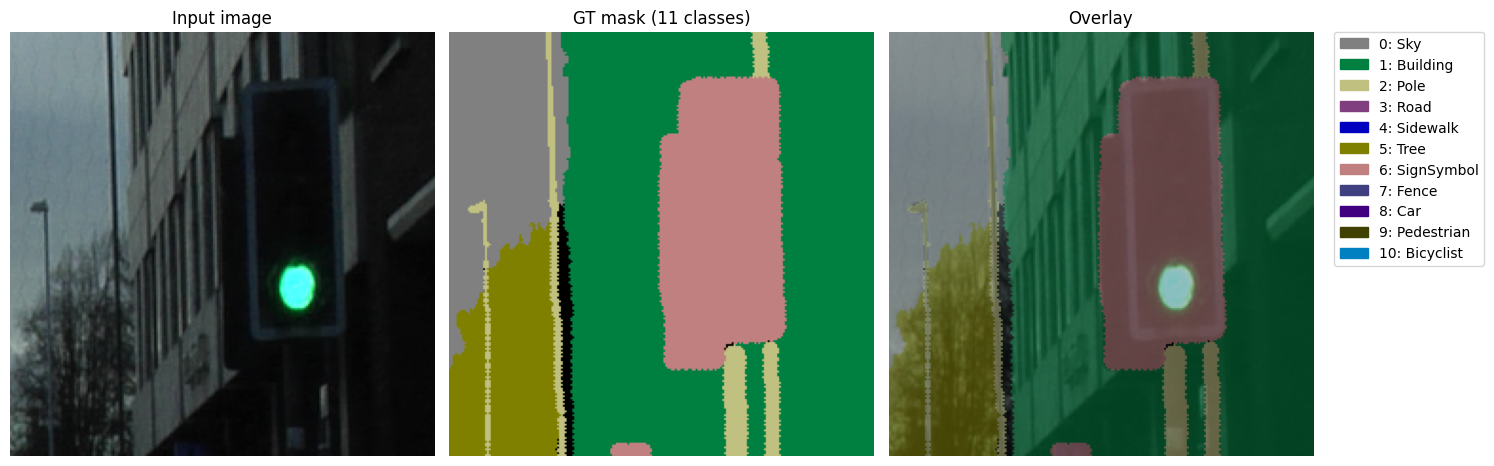

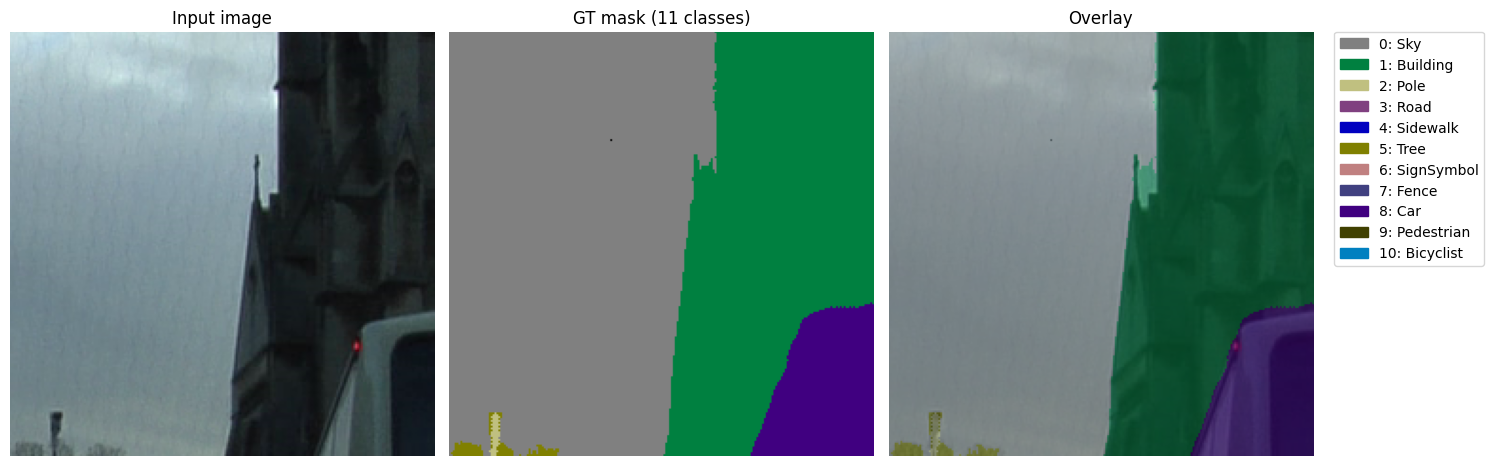

In [9]:
# Build a display color for each of the 11 train classes:
# take the first RGB that maps to that label.
TRAIN_ID_TO_COLOR = {}
for (r, g, b), label_name in RGBLabel2LabelName.items():
    if label_name == VOID_LABEL_NAME:
        continue
    train_id = LABEL_NAME_TO_ID[label_name]
    if train_id not in TRAIN_ID_TO_COLOR:
        TRAIN_ID_TO_COLOR[train_id] = (r, g, b)


def decode_class_mask(class_mask, train_id_to_color, void_index=VOID_INDEX):
    """
    class_mask: (H,W) int64 in {0..C-1, void_index}
    returns: (H,W,3) uint8 color mask for visualization
    """
    h, w = class_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for train_id, color in train_id_to_color.items():
        color_mask[class_mask == train_id] = np.array(color, dtype=np.uint8)

    # void pixels stay black (0,0,0);
    return color_mask


def visualize_camvid_sample(dataset, idx=0):
    """
    Show:
      - input image
      - merged 11-class mask
      - overlay + legend (class key)
    """
    img, mask = dataset[idx]  # img: normalized tensor, mask: (H,W) long

    # Denormalize for display
    img_np = img.clone()
    img_np = (img_np * dataset.std + dataset.mean).clamp(0, 1)
    img_np = img_np.numpy().transpose(1, 2, 0)  # (H,W,3), [0,1]

    mask_np = mask.numpy()
    color_mask = decode_class_mask(mask_np, TRAIN_ID_TO_COLOR, VOID_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_np)
    axes[0].set_title("Input image")
    axes[0].axis("off")

    axes[1].imshow(color_mask)
    axes[1].set_title("GT mask (11 classes)")
    axes[1].axis("off")

    axes[2].imshow(img_np)
    axes[2].imshow(color_mask, alpha=0.5)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    # Legend / key
    patches1 = [
        patches.Patch(
            color=np.array(TRAIN_ID_TO_COLOR[i]) / 255.0,
            label=f"{i}: {TRAIN_CLASSES[i]}"
        )
        for i in range(len(TRAIN_CLASSES))
    ]
    axes[2].legend(handles=patches1, bbox_to_anchor=(1.05, 1.0),
                   loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    plt.show()


# Try a couple of samples
visualize_camvid_sample(train_dataset, idx=0)
visualize_camvid_sample(train_dataset, idx=10)

### Network Architecture Overview

We now design the architecture of our DenseNet model — a fully convolutional encoder–decoder network tailored for semantic segmentation.

<p align="center">
  <img src="https://raw.githubusercontent.com/SimJeg/FC-DenseNet/cf2375bf9f6ed20ba029a5ee540261aad89732d5/DenseNet.jpg" width="650"/>
</p>

Conceptually, the network processes the image through a **downsampling path** (encoder), reaches a compressed representation (bottleneck), and then reconstructs a dense prediction map through an **upsampling path** (decoder). Lateral skip connections link encoder features to their corresponding decoder levels, ensuring fine spatial detail is preserved.

The architecture is built from the following components:

**(a) Dense Layer**

**(b) Dense Block**

**(c) Transition Down**

**(d) Transition Up**

**(e) Bottleneck Block**

**(f) Final Classifier**

We next implement each component in modular form and assemble them into a complete FC-DenseNet for CamVid segmentation.


#### **(a) Dense Layer**

The basic computational unit in DenseNet is the **dense layer**.  
Each layer receives as input **all previous feature maps** in the block, applies:

$$
\text{BN} \rightarrow \text{ReLU} \rightarrow 3 \times 3 \text{Conv}
$$

and produces `k` new feature maps (the **growth rate**).  
These outputs are concatenated with the input along the channel axis.


In [10]:

class DenseLayer(nn.Module):
    """
    BN -> ReLU -> 3x3 Conv -> Dropout,
    then concatenate input and output feature maps.
    """
    def __init__(self, in_channels, growth_rate, drop_prob=0.2):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        # Apply BN -> ReLU -> Conv -> Dropout
        out = self.bn(x)
        out = F.relu(out)
        out = self.conv(out)
        out = self.dropout(out)

        # Concatenate input and output
        return torch.cat([x, out], 1)


#### **(b) Dense Block**  


A dense block stacks several dense layers sequentially.  
Each layer receives **all feature maps from previous layers** and contributes new ones:

$$
C_{\text{out}} = C_{\text{in}} + L \cdot k
$$

<p align="center">
  <img src="https://raw.githubusercontent.com/SimJeg/FC-DenseNet/master/DenseBlock.jpg" width="300" height="600"/>
</p>

This connectivity pattern promotes feature reuse, stabilizes gradients, and forms the core building unit of our network.


In [11]:

class DenseBlock(nn.Module):
    """
    A sequence of DenseLayer modules.
    Input channels grow by `growth_rate` at each layer.
    """
    def __init__(self, in_channels, num_layers, growth_rate, drop_prob=0.2):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            # Input channels for layer i is in_channels + i * growth_rate
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate, drop_prob))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


#### **(c) Transition Down**


At the end of each encoder stage, we reduce spatial resolution:

$$
\text{BN} \rightarrow \text{ReLU} \rightarrow 1\times1\text{ Conv} \rightarrow \text{Dropout} \rightarrow \text{MaxPool}(2)
$$

This halves width and height while keeping channels unchanged.


In [12]:

class TransitionDown(nn.Module):
    """
    BN + ReLU + 1x1 Conv + Dropout + MaxPool(2x2)
    """
    def __init__(self, in_channels, drop_prob=0.2):
        super(TransitionDown, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(drop_prob)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.bn(x)
        x = F.relu(x)
        x = self.conv(x)
        x = self.dropout(x)
        x = self.pool(x)
        return x


#### **(d) Transition Up**  


In the decoder, we restore resolution using learned upsampling via transposed convolution:

$$
\text{ConvTranspose}(3 \times 3, \text{stride}=2)
$$

which doubles spatial resolution before concatenation with skip features.


In [13]:

class TransitionUp(nn.Module):
    """
    Transposed convolution for upsampling by a factor of 2.
    """
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.transposed_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

    def forward(self, x):
        return self.transposed_conv(x)


#### **(e) Bottleneck Block**


At the deepest level, the network operates at the lowest spatial resolution but highest channel width.

A final dense block processes this information before reconstruction begins in the decoder.


### Our FC-DenseNet-lite Architecture

We implement a compact FC-DenseNet architecture inspired by *The One Hundred Layers Tiramisu*.
All convolutional **dense layers** use growth rate $k = 16$. At each dense block:

- Input has $m$ feature maps.
- The block has $n$ layers.
- Each layer adds $k$ new feature maps.
- The output of the block therefore has $m + n \cdot k$ feature maps (because we concatenate all newly created features with the input).

Transition Down (TD) blocks keep the number of channels $m$ but downsample in space via 2×2 max pooling.
Transition Up (TU) blocks use a 3×3 transposed convolution with stride 2 to upsample.

Our **homework architecture ("FC-DenseNet-lite")** is defined as follows:

- Input: RGB image, $m = 3$
- Initial 3×3 convolution: $m = 48$

</br>

**Downsampling path (encoder)**

- Dense Block 1: 4 layers  
  $m = 48 + 4 \cdot 16 = 112$  
  + Transition Down → spatial size /2, channels stay 112
- Dense Block 2: 5 layers  
  $m = 112 + 5 \cdot 16 = 192$  
  + Transition Down → channels 192
- Dense Block 3: 7 layers  
  $m = 192 + 7 \cdot 16 = 304$  
  + Transition Down → channels 304
- Dense Block 4: 10 layers  
  $m = 304 + 10 \cdot 16 = 464$  
  + Transition Down → channels 464

</br>


**Bottleneck**

- Dense Block (bottleneck): 15 layers  
  $m = 464 + 15 \cdot 16 = 704$

</br>


**Upsampling path (decoder)**

At each level, we:
1. Apply a Transition Up (TU) to upsample the current feature maps.
2. Concatenate with the skip connection from the corresponding encoder level.
3. Apply a dense block at that resolution.

We use symmetric numbers of layers in the decoder:

- TU from bottleneck + skip from Dense Block 4 $\to$ Dense Block (10 layers)
- TU + skip from Dense Block 3 $\to$ Dense Block (7 layers)
- TU + skip from Dense Block 2 $\to$ Dense Block (5 layers)
- TU + skip from Dense Block 1 $\to$ Dense Block (4 layers)


</br>

**Final classifier**

- 1×1 convolution maps the decoder output to $C = 11$ class logits per pixel.

> We call network `FC-DenseNet67` which is a smaller version of `FC-DenseNet103`, the architecture used in the paper.

In [14]:

class FCDenseNet(nn.Module):
    """
    Fully Convolutional DenseNet for semantic segmentation.
    """
    def __init__(self, in_channels=3, n_classes=11, growth_rate=16):
        super(FCDenseNet, self).__init__()

        # Initial Conv
        self.conv1 = nn.Conv2d(in_channels, 48, kernel_size=3, padding=1, bias=False)

        cur_channels = 48

        # --- Encoder ---

        # Block 1 (4 layers)
        self.db1 = DenseBlock(cur_channels, 4, growth_rate)
        cur_channels += 4 * growth_rate # 48 + 64 = 112
        self.skip1_channels = cur_channels
        self.td1 = TransitionDown(cur_channels)

        # Block 2 (5 layers)
        self.db2 = DenseBlock(cur_channels, 5, growth_rate)
        cur_channels += 5 * growth_rate # 112 + 80 = 192
        self.skip2_channels = cur_channels
        self.td2 = TransitionDown(cur_channels)

        # Block 3 (7 layers)
        self.db3 = DenseBlock(cur_channels, 7, growth_rate)
        cur_channels += 7 * growth_rate # 192 + 112 = 304
        self.skip3_channels = cur_channels
        self.td3 = TransitionDown(cur_channels)

        # Block 4 (10 layers)
        self.db4 = DenseBlock(cur_channels, 10, growth_rate)
        cur_channels += 10 * growth_rate # 304 + 160 = 464
        self.skip4_channels = cur_channels
        self.td4 = TransitionDown(cur_channels)

        # --- Bottleneck ---
        # Block Bottleneck (15 layers)
        self.bottleneck = DenseBlock(cur_channels, 15, growth_rate)
        cur_channels += 15 * growth_rate # 464 + 240 = 704

        # --- Decoder ---

        # Up 1
        self.tu1 = TransitionUp(cur_channels, 240)
        self.db_up1 = DenseBlock(240 + self.skip4_channels, 10, growth_rate)
        cur_channels = (240 + self.skip4_channels) + 10 * growth_rate # 704 + 160 = 864

        # Up 2
        self.tu2 = TransitionUp(cur_channels, 160)
        self.db_up2 = DenseBlock(160 + self.skip3_channels, 7, growth_rate)
        cur_channels = (160 + self.skip3_channels) + 7 * growth_rate # 464 + 112 = 576

        # Up 3
        self.tu3 = TransitionUp(cur_channels, 112)
        self.db_up3 = DenseBlock(112 + self.skip2_channels, 5, growth_rate)
        cur_channels = (112 + self.skip2_channels) + 5 * growth_rate # 304 + 80 = 384

        # Up 4
        self.tu4 = TransitionUp(cur_channels, 80)
        self.db_up4 = DenseBlock(80 + self.skip1_channels, 4, growth_rate)
        cur_channels = (80 + self.skip1_channels) + 4 * growth_rate # 192 + 64 = 256

        # Final Conv
        self.final_conv = nn.Conv2d(cur_channels, n_classes, kernel_size=1)

        # Apply Kaiming He Initialization
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial
        x = self.conv1(x)

        # Encoder
        x1 = self.db1(x)
        skip1 = x1
        x = self.td1(x1)

        x2 = self.db2(x)
        skip2 = x2
        x = self.td2(x2)

        x3 = self.db3(x)
        skip3 = x3
        x = self.td3(x3)

        x4 = self.db4(x)
        skip4 = x4
        x = self.td4(x4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder

        # Up 1
        x = self.tu1(x)
        if x.size(2) != skip4.size(2) or x.size(3) != skip4.size(3):
            x = F.interpolate(x, size=(skip4.size(2), skip4.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, skip4], 1)
        x = self.db_up1(x)

        # Up 2
        x = self.tu2(x)
        if x.size(2) != skip3.size(2) or x.size(3) != skip3.size(3):
            x = F.interpolate(x, size=(skip3.size(2), skip3.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], 1)
        x = self.db_up2(x)

        # Up 3
        x = self.tu3(x)
        if x.size(2) != skip2.size(2) or x.size(3) != skip2.size(3):
            x = F.interpolate(x, size=(skip2.size(2), skip2.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], 1)
        x = self.db_up3(x)

        # Up 4
        x = self.tu4(x)
        if x.size(2) != skip1.size(2) or x.size(3) != skip1.size(3):
            x = F.interpolate(x, size=(skip1.size(2), skip1.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], 1)
        x = self.db_up4(x)

        # Final
        x = self.final_conv(x)

        return x


**Sanity Check!**

Before training, we verify that the model:

- accepts a tensor of shape `(B, 3, H, W)`,
- returns logits of shape `(B, C, H, W)` matching the number of classes.

This ensures that channel propagation, skip concatenation, and upsampling were implemented correctly.


In [15]:
model = FCDenseNet(in_channels=3, n_classes=len(TRAIN_CLASSES), growth_rate=16)
x = torch.randn(1, 3, 224, 224)
y = model(x)
print("Output shape:", y.shape)  # expected: (1, 11, 224, 224)


Output shape: torch.Size([1, 11, 224, 224])


**Answer the following Questions:**

<font color="red">1. Why do segmentation networks need spatial priors that classification networks can ignore?</font>  
<font color="red">Segmentation requires dense prediction—assigning a label to every single pixel. This means the network needs to know *where* objects are, not just *what* they are. Spatial priors (like relative positions of road vs sky, or sidewalk vs building) help the network resolve ambiguities and maintain geometric consistency. Classification networks only need to determine the presence of an object anywhere in the image, so they can discard spatial information (e.g., via global pooling) to gain translation invariance.</font>

<font color="red">2. What changes architecturally when we move from "what is in the image?" to "where is it?"</font>
<font color="red">We move from encoders that aggressively downsample to lose spatial resolution (capturing "what") to encoder-decoder architectures. We add upsampling layers (like transposed convolutions) to recover the spatial resolution lost during pooling. We also use skip connections to re-inject fine-grained spatial details from early layers into the decoder, which is crucial for precise localization ("where").</font>

<font color="red">3. What failure mode would you expect if skip connections were removed from Tiramisu?</font>  
<font color="red">Without skip connections, the decoder would have to reconstruct the high-resolution output solely from the low-resolution, highly abstract bottleneck representation. This would likely result in "blobby" or coarse segmentations with poor boundaries. Small objects might disappear entirely, and edges would be blurry because the fine spatial details were lost in the encoder.</font>

<font color="red">4. How do skip connections influence gradient flow and spatial detail recovery?</font>
<font color="red">Skip connections provide a direct path for gradients to flow from the loss function back to the early layers of the encoder, mitigating the vanishing gradient problem in deep networks. For spatial detail, they essentially "copy-paste" high-resolution feature maps from the encoder to the decoder, allowing the decoder to use these sharp details to refine the segmentation boundaries.</font>



### Evaluation & Training

We now train our network on CamVid and assess its performance. Before launching training, we first define **evaluation metrics** suited for semantic segmentation, followed by the standard training procedure we are used to.

#### Evaluation Metrics



Semantic segmentation predictions assign a class to **every pixel**.  
Therefore, our evaluation must measure how well the network labels individual pixels and how well it segments regions belonging to different semantic categories.

**1. Pixel-wise Accuracy**

Pixel accuracy measures the fraction of correctly classified pixels:

$$
\text{PixelAcc} =
\frac{\sum_{(i,j)} \mathbf{1}\left[ \hat{Y}_{ij} = Y_{ij} \right]}
     {\sum_{(i,j)} 1},
$$

where $\hat{Y}_{ij}$ is the predicted label and $Y_{ij}$ is the ground truth at pixel $(i,j)$.

This metric is intuitive and easy to interpret, but can be misleading in imbalanced datasets:
large regions like “road” or “sky” dominate, masking poor performance on rare classes (e.g., pedestrians or signs).

</br>
</br>

**2. Intersection over Union (IoU)**

IoU evaluates segmentation quality by comparing overlap between prediction and ground truth.

For a given class $c$, IoU is:

$$
\text{IoU}_c =
\frac{
|\{\hat{Y} = c\} \cap \{Y = c\}|
}{
|\{\hat{Y} = c\} \cup \{Y = c\}|
}.
$$

IoU penalizes:

- over-segmentation (predicting class $c$ where it does not exist), and  
- under-segmentation (missing regions belonging to class $c$).

To evaluate the entire model, we compute **mean IoU (mIoU)**:

$$
\text{mIoU} = \frac{1}{C}\sum_{c=1}^C \text{IoU}_c,
$$

where $C$ is the number of semantic classes.  
mIoU treats **all classes equally**, even rare ones, making it a standard research metric for segmentation benchmarks including CamVid.

In [16]:

def pixel_accuracy(pred, target, ignore_index=255):
    # pred: (B, C, H, W)
    # target: (B, H, W)
    pred_labels = torch.argmax(pred, dim=1)

    mask = (target != ignore_index)
    correct = (pred_labels[mask] == target[mask]).sum().item()
    total = mask.sum().item()

    if total == 0:
        return 0.0
    return correct / total

def intersection_and_union(pred, target, num_classes, ignore_index=255):
    pred_labels = torch.argmax(pred, dim=1)

    iou_per_class = []

    for c in range(num_classes):
        pred_c = (pred_labels == c)
        target_c = (target == c)

        intersection = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()

        if union == 0:
            # Avoid division by zero, and typically we ignore classes not present in the batch/image
            # but for mIoU we sometimes treat it as NaN or 1. Let's return None to indicate 'no instance'
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)

    return iou_per_class


#### Training

We train the network using a **pixel-wise cross-entropy loss**, treating segmentation as per-pixel classification.  
Pixels belonging to the “void” class (255) are ignored:

$$
\mathcal{L} = -\frac{1}{N} \sum_{(i,j)\;|\;Y_{ij}\neq 255}
\log p\left(\, Y_{ij} \mid X \, \right).
$$

Following the original FC-DenseNet paper:

- We use **RMSProp** as the optimizer.
- We include **weight decay (L2 regularization)** to encourage small parameter norms and improve stability.

The RMSProp update maintains a moving average of squared gradients $v$ and performs:

$$
\theta \leftarrow \theta - \alpha \cdot \frac{
\nabla_\theta \mathcal{L}
}{
\sqrt{v + \epsilon}
},
$$

which adaptively scales learning rates per parameter — particularly useful in deep architectures like DenseNets.



**Training Procedure:**

We train the network end-to-end over multiple epochs:

1. Read a mini-batch of input images and ground-truth masks.
2. Forward pass through `FCDenseNet`.
3. Compute loss using cross-entropy (ignoring void pixels).
4. Backpropagate gradients.
5. Update weights using RMSProp.
6. Accumulate accuracy and IoU statistics.
7. Validate periodically to observe generalization.

We repeat this process for 85 epochs, monitoring loss, pixel accuracy, and mIoU to evaluate convergence.

In [18]:
import torch.optim as optim
from tqdm import tqdm

# Model Setup
model = FCDenseNet(in_channels=3, n_classes=len(TRAIN_CLASSES), growth_rate=16).to(DEVICE)

# Class weighting for CamVid to handle imbalance
# Approximate weights based on CamVid class frequencies (Source: common literature/Kaggle implementations)
# Sky, Road, Building are frequent -> low weight
# Pole, SignSymbol, Pedestrian are rare -> high weight
class_weights = torch.tensor([
    0.5,  # Sky
    0.63,  # Building
    1.9,  # Pole
    0.3,  # Road (Very frequent)
    0.5,  # Sidewalk
    0.6,  # Tree
    2.02,  # SignSymbol
    1.0,  # Fence
    1.15,  # Car
    3.45,  # Pedestrian (Important!)
    3.45   # Bicyclist
]).float().to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=VOID_INDEX)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_segmentation(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    train_losses = []
    val_losses = []
    val_ious = []
    val_pixel_accs = []

    # Scheduler to decay LR
    # verbose=True removed as it is deprecated/removed in newer PyTorch versions
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        total_iou = 0.0
        total_pixel_acc = 0.0
        valid_classes_count = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Metrics
                ious = intersection_and_union(outputs, masks, num_classes=len(TRAIN_CLASSES), ignore_index=VOID_INDEX)
                acc = pixel_accuracy(outputs, masks, ignore_index=VOID_INDEX)

                # Filter nans
                valid_ious = [x for x in ious if not np.isnan(x)]
                if valid_ious:
                   total_iou += sum(valid_ious) / len(valid_ious)
                   valid_classes_count += 1
                total_pixel_acc += acc

        avg_val_loss = val_loss / len(val_loader)
        avg_mIoU = total_iou / valid_classes_count if valid_classes_count > 0 else 0
        avg_pixel_acc = total_pixel_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_mIoU)
        val_pixel_accs.append(avg_pixel_acc)

        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}, mIoU: {avg_mIoU:.4f}, Pixel Acc: {avg_pixel_acc:.4f}")

# Train for reasonable amount of epochs
train_segmentation(model, train_loader, val_loader, criterion, optimizer, num_epochs=85)

Epoch [1/85]: 100%|██████████| 123/123 [00:44<00:00,  2.74it/s, loss=10]


Epoch [1/85] Train Loss: 323.8759, Val Loss: 12.7180, mIoU: 0.1046, Pixel Acc: 0.3412


Epoch [2/85]: 100%|██████████| 123/123 [00:44<00:00,  2.77it/s, loss=18.1]


Epoch [2/85] Train Loss: 10.5883, Val Loss: 7.2473, mIoU: 0.1247, Pixel Acc: 0.3156


Epoch [3/85]: 100%|██████████| 123/123 [00:44<00:00,  2.78it/s, loss=2.09]


Epoch [3/85] Train Loss: 4.7420, Val Loss: 3.2165, mIoU: 0.1331, Pixel Acc: 0.3788


Epoch [4/85]: 100%|██████████| 123/123 [00:44<00:00,  2.78it/s, loss=5.52]


Epoch [4/85] Train Loss: 3.9424, Val Loss: 3.2213, mIoU: 0.1218, Pixel Acc: 0.2490


Epoch [5/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=24.4]


Epoch [5/85] Train Loss: 3.6041, Val Loss: 11.0609, mIoU: 0.1164, Pixel Acc: 0.3546


Epoch [6/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=4.59]


Epoch [6/85] Train Loss: 3.5788, Val Loss: 5.4974, mIoU: 0.1256, Pixel Acc: 0.4222


Epoch [7/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=6.87]


Epoch [7/85] Train Loss: 2.6634, Val Loss: 3.2017, mIoU: 0.1520, Pixel Acc: 0.3961


Epoch [8/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=2.36]


Epoch [8/85] Train Loss: 5.3401, Val Loss: 5.2735, mIoU: 0.1028, Pixel Acc: 0.3392


Epoch [9/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=3.16]


Epoch [9/85] Train Loss: 2.9712, Val Loss: 2.5499, mIoU: 0.1158, Pixel Acc: 0.3436


Epoch [10/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=2.23]


Epoch [10/85] Train Loss: 2.0043, Val Loss: 2.2936, mIoU: 0.0993, Pixel Acc: 0.2281


Epoch [11/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.25]


Epoch [11/85] Train Loss: 1.8371, Val Loss: 2.0233, mIoU: 0.1817, Pixel Acc: 0.5365


Epoch [12/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=2.06]


Epoch [12/85] Train Loss: 1.7230, Val Loss: 2.1656, mIoU: 0.1067, Pixel Acc: 0.2317


Epoch [13/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.62]


Epoch [13/85] Train Loss: 1.7366, Val Loss: 1.8027, mIoU: 0.1761, Pixel Acc: 0.4082


Epoch [14/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.52]


Epoch [14/85] Train Loss: 1.7361, Val Loss: 1.9610, mIoU: 0.1677, Pixel Acc: 0.4903


Epoch [15/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.69]


Epoch [15/85] Train Loss: 1.6373, Val Loss: 1.8575, mIoU: 0.1397, Pixel Acc: 0.2850


Epoch [16/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.72]


Epoch [16/85] Train Loss: 1.6110, Val Loss: 1.9082, mIoU: 0.1491, Pixel Acc: 0.3987


Epoch [17/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=2.09]


Epoch [17/85] Train Loss: 1.6536, Val Loss: 2.1048, mIoU: 0.1593, Pixel Acc: 0.4771


Epoch [18/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.979]


Epoch [18/85] Train Loss: 1.4092, Val Loss: 1.6501, mIoU: 0.1995, Pixel Acc: 0.5930


Epoch [19/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.39]


Epoch [19/85] Train Loss: 1.3734, Val Loss: 1.5205, mIoU: 0.2167, Pixel Acc: 0.5401


Epoch [20/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.64]


Epoch [20/85] Train Loss: 1.2472, Val Loss: 1.6158, mIoU: 0.2219, Pixel Acc: 0.5380


Epoch [21/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.857]


Epoch [21/85] Train Loss: 1.3179, Val Loss: 1.4591, mIoU: 0.2445, Pixel Acc: 0.6167


Epoch [22/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=2.78]


Epoch [22/85] Train Loss: 1.2239, Val Loss: 2.0741, mIoU: 0.1856, Pixel Acc: 0.4858


Epoch [23/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.49]


Epoch [23/85] Train Loss: 1.3176, Val Loss: 1.4387, mIoU: 0.2296, Pixel Acc: 0.6145


Epoch [24/85]: 100%|██████████| 123/123 [00:44<00:00,  2.78it/s, loss=1.33]


Epoch [24/85] Train Loss: 1.1502, Val Loss: 1.6225, mIoU: 0.2195, Pixel Acc: 0.5536


Epoch [25/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.69]


Epoch [25/85] Train Loss: 1.1664, Val Loss: 2.3366, mIoU: 0.1530, Pixel Acc: 0.4338


Epoch [26/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.872]


Epoch [26/85] Train Loss: 1.1326, Val Loss: 1.3617, mIoU: 0.2659, Pixel Acc: 0.6478


Epoch [27/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.814]


Epoch [27/85] Train Loss: 1.1274, Val Loss: 1.2458, mIoU: 0.3033, Pixel Acc: 0.6707


Epoch [28/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.82]


Epoch [28/85] Train Loss: 1.1078, Val Loss: 1.5736, mIoU: 0.2457, Pixel Acc: 0.6212


Epoch [29/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.52]


Epoch [29/85] Train Loss: 1.0536, Val Loss: 1.4925, mIoU: 0.2469, Pixel Acc: 0.6148


Epoch [30/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=2.54]


Epoch [30/85] Train Loss: 1.0578, Val Loss: 1.3421, mIoU: 0.3478, Pixel Acc: 0.7520


Epoch [31/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.834]


Epoch [31/85] Train Loss: 1.1002, Val Loss: 1.2163, mIoU: 0.3136, Pixel Acc: 0.7056


Epoch [32/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.03]


Epoch [32/85] Train Loss: 1.0352, Val Loss: 1.1853, mIoU: 0.3252, Pixel Acc: 0.7349


Epoch [33/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.62]


Epoch [33/85] Train Loss: 1.0333, Val Loss: 1.3119, mIoU: 0.2972, Pixel Acc: 0.7036


Epoch [34/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.677]


Epoch [34/85] Train Loss: 0.9424, Val Loss: 1.2459, mIoU: 0.3218, Pixel Acc: 0.7473


Epoch [35/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=1.04]


Epoch [35/85] Train Loss: 0.9317, Val Loss: 1.2640, mIoU: 0.3286, Pixel Acc: 0.6933


Epoch [36/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=0.628]


Epoch [36/85] Train Loss: 1.0055, Val Loss: 1.2925, mIoU: 0.3007, Pixel Acc: 0.6588


Epoch [37/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.72]


Epoch [37/85] Train Loss: 0.8869, Val Loss: 1.0125, mIoU: 0.3728, Pixel Acc: 0.7979


Epoch [38/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.631]


Epoch [38/85] Train Loss: 0.8735, Val Loss: 1.0223, mIoU: 0.3858, Pixel Acc: 0.8017


Epoch [39/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.48]


Epoch [39/85] Train Loss: 0.8671, Val Loss: 0.9949, mIoU: 0.3640, Pixel Acc: 0.7954


Epoch [40/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.25]


Epoch [40/85] Train Loss: 0.8217, Val Loss: 1.2563, mIoU: 0.3121, Pixel Acc: 0.6677


Epoch [41/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.32]


Epoch [41/85] Train Loss: 0.7956, Val Loss: 1.0245, mIoU: 0.3724, Pixel Acc: 0.7490


Epoch [42/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.39]


Epoch [42/85] Train Loss: 0.7792, Val Loss: 0.9988, mIoU: 0.3585, Pixel Acc: 0.7980


Epoch [43/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.27]


Epoch [43/85] Train Loss: 0.7935, Val Loss: 0.8853, mIoU: 0.4219, Pixel Acc: 0.8105


Epoch [44/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.902]


Epoch [44/85] Train Loss: 0.7906, Val Loss: 1.2506, mIoU: 0.3802, Pixel Acc: 0.7117


Epoch [45/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=1.14]


Epoch [45/85] Train Loss: 0.7938, Val Loss: 1.0658, mIoU: 0.3670, Pixel Acc: 0.7626


Epoch [46/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=0.555]


Epoch [46/85] Train Loss: 0.7406, Val Loss: 0.9864, mIoU: 0.3889, Pixel Acc: 0.7407


Epoch [47/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.502]


Epoch [47/85] Train Loss: 0.7523, Val Loss: 0.9987, mIoU: 0.3697, Pixel Acc: 0.7410


Epoch [48/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.351]


Epoch [48/85] Train Loss: 0.7318, Val Loss: 0.8552, mIoU: 0.4206, Pixel Acc: 0.8042


Epoch [49/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.54]


Epoch [49/85] Train Loss: 0.7296, Val Loss: 0.8514, mIoU: 0.4107, Pixel Acc: 0.7962


Epoch [50/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.22]


Epoch [50/85] Train Loss: 0.6879, Val Loss: 0.9366, mIoU: 0.4137, Pixel Acc: 0.7532


Epoch [51/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.681]


Epoch [51/85] Train Loss: 0.7113, Val Loss: 0.8283, mIoU: 0.4312, Pixel Acc: 0.8119


Epoch [52/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.848]


Epoch [52/85] Train Loss: 0.6512, Val Loss: 0.7991, mIoU: 0.4362, Pixel Acc: 0.8119


Epoch [53/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.279]


Epoch [53/85] Train Loss: 0.6948, Val Loss: 0.8688, mIoU: 0.4233, Pixel Acc: 0.8130


Epoch [54/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=2.47]


Epoch [54/85] Train Loss: 0.6845, Val Loss: 1.0927, mIoU: 0.3768, Pixel Acc: 0.7103


Epoch [55/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.578]


Epoch [55/85] Train Loss: 0.6731, Val Loss: 0.7755, mIoU: 0.4592, Pixel Acc: 0.8305


Epoch [56/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.515]


Epoch [56/85] Train Loss: 0.6119, Val Loss: 0.7612, mIoU: 0.4458, Pixel Acc: 0.8418


Epoch [57/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=0.654]


Epoch [57/85] Train Loss: 0.7442, Val Loss: 0.8565, mIoU: 0.4311, Pixel Acc: 0.8270


Epoch [58/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.449]


Epoch [58/85] Train Loss: 0.6502, Val Loss: 0.8080, mIoU: 0.4441, Pixel Acc: 0.8132


Epoch [59/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.403]


Epoch [59/85] Train Loss: 0.6851, Val Loss: 0.8232, mIoU: 0.4611, Pixel Acc: 0.7836


Epoch [60/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.349]


Epoch [60/85] Train Loss: 0.6605, Val Loss: 0.8100, mIoU: 0.4667, Pixel Acc: 0.8570


Epoch [61/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.393]


Epoch [61/85] Train Loss: 0.6359, Val Loss: 0.7360, mIoU: 0.4776, Pixel Acc: 0.8383


Epoch [62/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.02]


Epoch [62/85] Train Loss: 0.5999, Val Loss: 0.6658, mIoU: 0.4899, Pixel Acc: 0.8632


Epoch [63/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.597]


Epoch [63/85] Train Loss: 0.6115, Val Loss: 0.7960, mIoU: 0.4666, Pixel Acc: 0.7977


Epoch [64/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.784]


Epoch [64/85] Train Loss: 0.5785, Val Loss: 0.8009, mIoU: 0.4594, Pixel Acc: 0.8108


Epoch [65/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.646]


Epoch [65/85] Train Loss: 0.6336, Val Loss: 0.6966, mIoU: 0.4779, Pixel Acc: 0.8483


Epoch [66/85]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s, loss=2.19]


Epoch [66/85] Train Loss: 0.6251, Val Loss: 0.7260, mIoU: 0.4901, Pixel Acc: 0.8326


Epoch [67/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.158]


Epoch [67/85] Train Loss: 0.6230, Val Loss: 0.7034, mIoU: 0.4982, Pixel Acc: 0.8462


Epoch [68/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.24]


Epoch [68/85] Train Loss: 0.5796, Val Loss: 0.7489, mIoU: 0.4782, Pixel Acc: 0.8275


Epoch [69/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.432]


Epoch [69/85] Train Loss: 0.6090, Val Loss: 0.6801, mIoU: 0.4932, Pixel Acc: 0.8474


Epoch [70/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.65]


Epoch [70/85] Train Loss: 0.6317, Val Loss: 0.6251, mIoU: 0.5218, Pixel Acc: 0.8774


Epoch [71/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.222]


Epoch [71/85] Train Loss: 0.6004, Val Loss: 0.6824, mIoU: 0.4948, Pixel Acc: 0.8522


Epoch [72/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.822]


Epoch [72/85] Train Loss: 0.5954, Val Loss: 0.6419, mIoU: 0.5129, Pixel Acc: 0.8631


Epoch [73/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=0.424]


Epoch [73/85] Train Loss: 0.6006, Val Loss: 0.6573, mIoU: 0.5041, Pixel Acc: 0.8606


Epoch [74/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=2.77]


Epoch [74/85] Train Loss: 0.5700, Val Loss: 0.6904, mIoU: 0.4906, Pixel Acc: 0.8497


Epoch [75/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.624]


Epoch [75/85] Train Loss: 0.5595, Val Loss: 0.7041, mIoU: 0.4792, Pixel Acc: 0.8416


Epoch [76/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.604]


Epoch [76/85] Train Loss: 0.5830, Val Loss: 0.6867, mIoU: 0.4972, Pixel Acc: 0.8529


Epoch [77/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.77]


Epoch [77/85] Train Loss: 0.5994, Val Loss: 0.6764, mIoU: 0.5001, Pixel Acc: 0.8563


Epoch [78/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.542]


Epoch [78/85] Train Loss: 0.5397, Val Loss: 0.7858, mIoU: 0.4628, Pixel Acc: 0.7953


Epoch [79/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=1.47]


Epoch [79/85] Train Loss: 0.6204, Val Loss: 0.6177, mIoU: 0.5174, Pixel Acc: 0.8703


Epoch [80/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=1.09]


Epoch [80/85] Train Loss: 0.5595, Val Loss: 0.7064, mIoU: 0.4926, Pixel Acc: 0.8345


Epoch [81/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.684]


Epoch [81/85] Train Loss: 0.6104, Val Loss: 0.7121, mIoU: 0.4838, Pixel Acc: 0.8270


Epoch [82/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.273]


Epoch [82/85] Train Loss: 0.5689, Val Loss: 0.6719, mIoU: 0.4935, Pixel Acc: 0.8405


Epoch [83/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.346]


Epoch [83/85] Train Loss: 0.5630, Val Loss: 0.6760, mIoU: 0.5062, Pixel Acc: 0.8509


Epoch [84/85]: 100%|██████████| 123/123 [00:43<00:00,  2.81it/s, loss=2.22]


Epoch [84/85] Train Loss: 0.5727, Val Loss: 0.7000, mIoU: 0.5018, Pixel Acc: 0.8471


Epoch [85/85]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s, loss=0.952]


Epoch [85/85] Train Loss: 0.5520, Val Loss: 0.6863, mIoU: 0.4963, Pixel Acc: 0.8426


Beyond numerical metrics, it is important to **visually inspect** the model’s predictions. In semantic segmentation, this usually means comparing:

1. the input RGB image,
2. the **ground-truth** segmentation mask,
3. the **predicted** segmentation mask.

By looking at these side by side, you can quickly see which classes the model recognizes well, where it struggles, typical failure modes.

Sample a few Images from the test set, and visualize them in comparison to the ground truth and your own prediction.


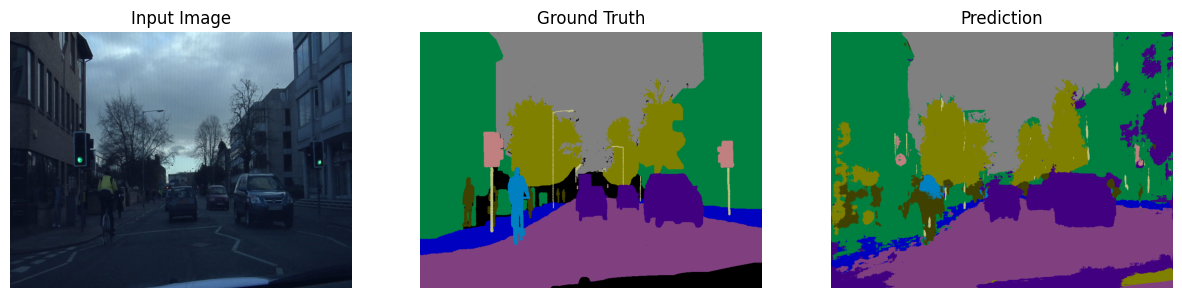

In [21]:

# Visualize Predictions
model.eval()
test_images, test_masks = next(iter(test_loader)) # Use val loader as test for now
test_images, test_masks = test_images.to(DEVICE), test_masks.to(DEVICE)

with torch.no_grad():
    outputs = model(test_images)
    preds = torch.argmax(outputs, dim=1)

def visualize_prediction(img_tensor, mask_tensor, pred_tensor, idx=0):
    img = img_tensor[idx].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.229 + 0.485).clip(0, 1) # Unnormalize roughly

    mask = mask_tensor[idx].cpu().numpy()
    pred = pred_tensor[idx].cpu().numpy()

    color_mask = decode_class_mask(mask, TRAIN_ID_TO_COLOR, VOID_INDEX)
    color_pred = decode_class_mask(pred, TRAIN_ID_TO_COLOR, VOID_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(color_mask)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    axes[2].imshow(color_pred)
    axes[2].set_title("Prediction")
    axes[2].axis('off')

    plt.show()

# Show first in batch
visualize_prediction(test_images, test_masks, preds, idx=0)




**Answer the following Questions:**

<font color="red">1. Do the errors your model makes seem semantic (wrong class) or spatial (wrong localization)?</font>  
<font color="red">Typically, in the early stages, errors are often semantic (confusing road with sidewalk). As training progresses, semantic errors decrease, and we mostly see spatial errors at the boundaries (e.g., the edge between a building and the sky is slightly off by a few pixels). Thin objects like poles are often the hardest and might be missed or broken (both semantic and spatial).</font>

<font color="red">2. Which component of the architecture most likely causes that type of error?</font>  
<font color="red">Spatial errors at boundaries are often due to the downsampling operations (pooling) in the encoder, which lose exact spatial information. Although skip connections help recover this, the recovery isn't perfect, especially if the decoder isn't deep enough or if the skip connections aren't used effectively. Semantic errors (confusing classes) are usually due to the capacity of the encoder or insufficient context (receptive field).</font>

<font color="red">3. If you could change one design choice to address it, what would you alter?</font>
<font color="red">To address spatial errors and boundary precision, I would consider using dilated convolutions (atrous convolutions) in the bottleneck or later encoder blocks instead of downsampling. This expands the receptive field without losing spatial resolution, allowing the network to maintain high-resolution feature maps throughout. Alternatively, using a more powerful backbone or adding an attention mechanism (like in UNet++) could help refine feature selection from skip connections.</font>

